# Decomposition into fine and coarse space

This script shows how the solution can be decomposed into its coarse part in $V_{H}$ and its finescale part in $V^f_h$. The example furthermore plots the standard FEM basis function next to the new basis for $V^{\text{ms}'}_H$.

In [1]:
import numpy as np
import scipy.sparse as sparse

import matplotlib.pyplot as plt
from visualize import drawCoefficient, d3plotter

from gridlod import interp, coef, util, fem
from gridlod.world import World
import buildcoef2d
import fem_solver_wave
import lod_wave

'''
Settings
'''

bg = 0.05
val = 1

# fine world
NWorldFine = np.array([128, 128])
NpFine = np.prod(NWorldFine + 1)

# coarse World
NWorldCoarse = np.array([8, 8])
NpCoarse = np.prod(NWorldCoarse + 1)

# fine coarse ratio
NCoarseElement = NWorldFine/NWorldCoarse

boundaryConditions = np.array([[0, 0],
                               [0, 0]])

world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

# source term
f = np.ones(NpCoarse)


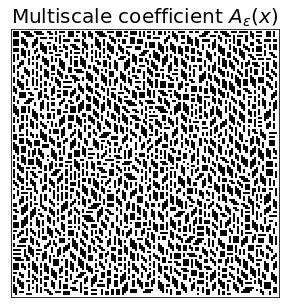

In [2]:
'''
Coefficients
'''

# coefficient A(x)
CoefClassA = buildcoef2d.Coefficient2d(NWorldFine,
                                            bg                  = bg,
                                            val                 = val,
                                            length              = 1,
                                            thick               = 1,
                                            space               = 1,
                                            probfactor          = 1,
                                            right               = 1,
                                            down                = 1,
                                            diagr1              = 1,
                                            diagr2              = 1,
                                            diagl1              = 1,
                                            diagl2              = 1,
                                            LenSwitch           = [1,2,3],
                                            thickSwitch         = [1,2,3],
                                            equidistant         = None,
                                            ChannelHorizontal   = None,
                                            ChannelVertical     = None,
                                            BoundarySpace       = None,
                                            Boxes2n             = None,
                                            Channels2n          = None,
                                            TestExample         = None)

A = CoefClassA.BuildCoefficient()
ABase = A.flatten()
plt.figure("OriginalCoefficient")
drawCoefficient(NWorldFine, ABase)
plt.title('Multiscale coefficient $A_{\epsilon}(x)$', fontsize=20)
plt.show()

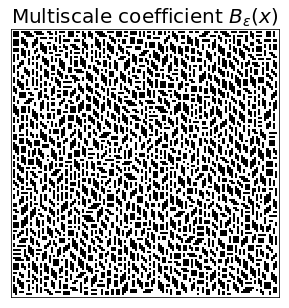

In [3]:
# coefficients B(x)
CoefClassB = buildcoef2d.Coefficient2d(NWorldFine,
                        bg                  = bg,
                        val                 = val,
                        length              = 4,
                        thick               = 1,
                        space               = 2,
                        probfactor          = 1,
                        right               = 0,
                        down                = 0,
                        diagr1              = 0,
                        diagr2              = 0,
                        diagl1              = 0,
                        diagl2              = 1,
                        LenSwitch           = None,
                        thickSwitch         = None,
                        equidistant         = None,
                        ChannelHorizontal   = None,
                        ChannelVertical     = None,
                        BoundarySpace       = True)

B = CoefClassB.BuildCoefficient()
BBase = B.flatten()
plt.figure("OriginalCoefficient")
drawCoefficient(NWorldFine, ABase)
plt.title('Multiscale coefficient $B_{\epsilon}(x)$', fontsize=20)
plt.show()

In [4]:

# time step parameters
tau = 0.1

# fine fem
f_fine = np.ones(NpFine)
Uo = np.zeros(NpFine)
Vo = np.ones(NpFine)
U = [Uo]

for i in xrange(5):
    uFineFem = fem_solver_wave.solveFine_fem(world, ABase, BBase, f_fine, U, tau, boundaryConditions, i)
    U.append(uFineFem)

# interpolant
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, NCoarseElement, boundaryConditions)

# coefficients
bCoef = coef.coefficientFine(NWorldCoarse, NCoarseElement, BBase)
aCoef = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

# evalaute on whole domain
k=np.inf

bCoef = coef.coefficientFine(NWorldCoarse, NCoarseElement, BBase)
aCoef = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase / tau)
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                              NCoarseElement, boundaryConditions)

pglod = lod_wave.LodWave(bCoef, world, k, IPatchGenerator, aCoef)
pglod.compute_basis_correctors()

KFull = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, BBase)
SFull = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, ABase)
MFull = fem.assemblePatchMatrix(NWorldFine, world.MLocFine)
free = util.interiorpIndexMap(NWorldCoarse)

bFull = MFull * f_fine

basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
basisCorrectors = pglod.assembleBasisCorrectors()
modifiedBasis = basis - basisCorrectors

KFull = basis.T * (KFull * modifiedBasis)
SFull = basis.T * (SFull * modifiedBasis)
MFull = basis.T * (MFull * modifiedBasis)
bFull = basis.T * bFull

MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
free  = util.interiorpIndexMap(NWorldCoarse)

bFull = MFull*f

KFree = KFull[free][:, free]
SFree = SFull[free][:, free]
MFree = MFull[free][:, free]
bFree = bFull[free]

A = (1. / tau ** 2) * MFree + (1. / tau) * SFree + KFree
b = bFree + (1. / tau) * SFree * Uo[free] + (1. / tau) * MFree * ((1. / tau) * Uo[free] + Vo[free])

xFree = sparse.linalg.spsolve(A, b)

basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
basisCorrectors = pglod.assembleBasisCorrectors()
modifiedBasis = basis - basisCorrectors

xFull = np.zeros(NpCoarse)
xFull[free] = xFree
uLodCoarse = xFull
uLodFine = modifiedBasis*xFull
diff = basis*uLodCoarse-uLodFine


# Plot the decomposition of the solution

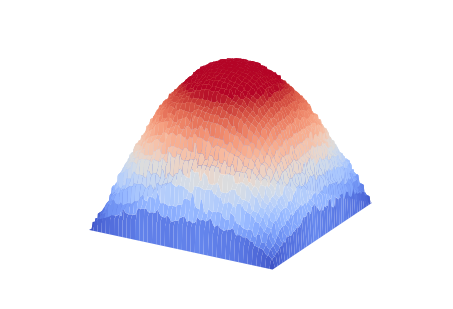

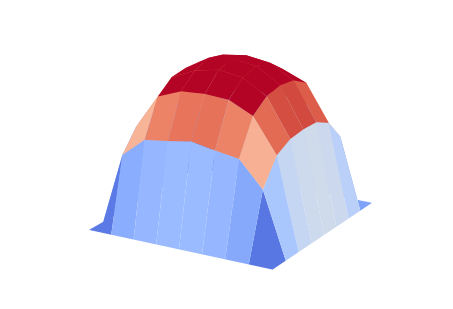

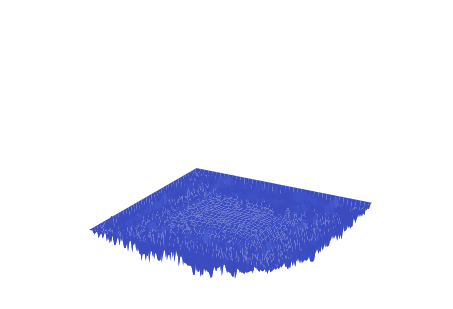

In [5]:
# plot multiscale splitting
d3plotter(NWorldFine, uFineFem,boundary=[np.min(uFineFem),np.max(uFineFem)-0.012])
d3plotter(NWorldCoarse, uLodCoarse, String='Coarse1', boundary=[np.min(uFineFem),np.max(uFineFem)-0.012])
d3plotter(NWorldFine, diff, String='uf2',boundary=[np.min(uFineFem),np.max(uFineFem)-0.03], Blues= True)

# Plot the basis functions

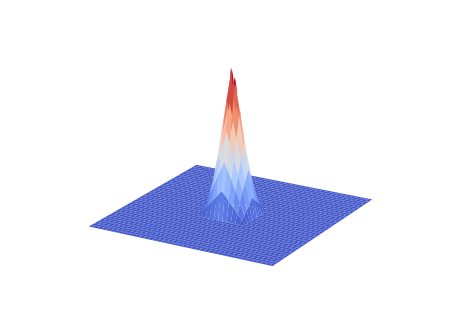

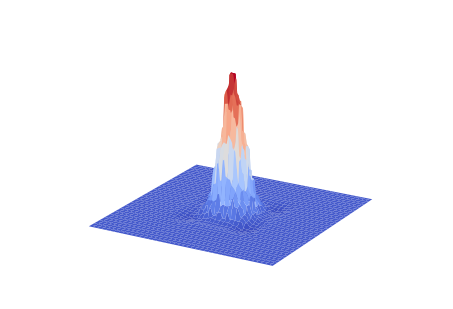

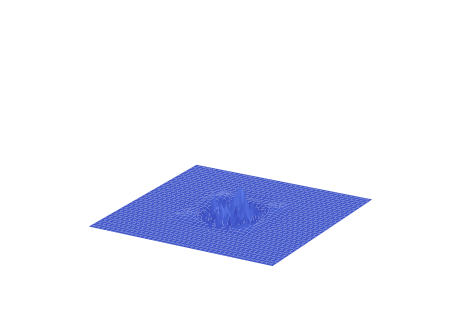

In [6]:
# plot for basis functions
bf = np.zeros(NpCoarse)
bf[40] = 1
hat_function = basis * bf
basis_correction = basisCorrectors * bf
ms_basis = modifiedBasis * bf
zmax = np.max(ms_basis)
zmin = np.min(ms_basis)
d3plotter(NWorldFine, hat_function, '1', zmax=zmax, zmin=zmin, Blues=True)
d3plotter(NWorldFine, ms_basis, '3', zmax=zmax-0.05, zmin=zmin)
d3plotter(NWorldFine, basis_correction, '2', zmax=zmax, zmin=zmin, Blues=True)

plt.show()